In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import random
import scipy
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull
from cycler import cycler
%matplotlib inline

# Define Units

Energy: MeV  
Mass:   MeV * c$^2$  
Time:   s  
Length: m   
Angles: Radians  

# Define Constants

In [2]:
alpha = 1/137
r_o = 2.81794e-15 #m
m_p = 938.272 #MeV/c^2
m_e = .511 #MeV/c^2
m_pi = 134.9766 #MeV/c^2
q = 1.6e-19
h = 4.136e-21 #MeV*s 
h_bar = 6.582119569e-22 #Mev*s
c  = 3e8
N_A = 6.022e23


rho = 916.7 #kg/m^3 at 0C and atmospheric pressure
Z_nuc = 7.42 #Z_eff for water
A_r = Z_nuc/.55509 #Z/A = .55509
n = 1.309 #index of refraction of ice
X_o = 1/(4*alpha*(r_o**2)*rho*(N_A/A_r)*Z_nuc*(1+Z_nuc)*np.log(183/(Z_nuc**(1/3))))
X_1 = 1433/(.916)*A_r/(Z_nuc*(Z_nuc+1)*(11.319-np.log(Z_nuc))) / 100.
X_o = X_1

abs_coeff   = 0.00853987      # according to Dima's data
abs_length  = 1 / abs_coeff
scat_coeff  = 0.0269972      # according to Dima's data
scat_length = 1 / scat_coeff

photon_mfp = 3 # meters, UPDATE

# detection_radius = .3 #half of the hole width
detection_radius = 10 # DOM oversizing
DOM_QE = .25

# Define different Particles

In [17]:
class Particle: 
    def __init__(self, particle_type, mass, charge, direction, location, energy, time):
        self.particle_type = particle_type
        self.mass = mass
        self.charge = charge
        self.location = location # array of [x, y, z] to describe location
        self.direction = direction # array of [theta, phi] in direction of travel
        self.theta = self.direction[0]
        self.phi = self.direction[1]
        self.energy = energy
        self.beta = np.sqrt(1-(self.mass/self.energy)**2)
        self.momentum = np.sqrt(self.energy**2-self.mass**2)/c 
        self.time = time
        
    def update_energy(self, new_energy):
        self.energy = new_energy
        self.beta = np.sqrt(1-(self.mass/self.energy)**2)
        self.momentum = np.sqrt(self.energy**2-self.mass**2)/c 

## Define Detector

In [44]:
class DOM:
    def __init__(self, location):
        self.location = location
        self.triggered = False
        self.signals = []
        self.times = []
        
    def distance_from(self, location): 
        x = location[0]
        y = location[1]
        z = location[2]
        dom_x = self.location[0]
        dom_y = self.location[1]
        dom_z = self.location[2]
        return np.sqrt((dom_x - x)**2 + (dom_y - y)**2 + (dom_z - z)**2)
    
    def trigger(self, time, num_photons=1): 
        self.triggered = True
        self.signals.append(num_photons)
        self.times.append(time)
        
    def clear_trigger(self):
        self.triggered = False
        self.signals = []
        self.times = []
    
class detector:
    def __init__(self, dom_list):
        self.dom_list = dom_list
        
    def num_triggered(self): 
        num_triggered = 0
        for dom in dom_list: 
            if dom.triggered: 
                num_triggered += 1
        return num_triggered
    
    def volume(self):
        points = [dom.location for dom in self.dom_list]
        region = ConvexHull(points)
        return region.volume

## Define Coordinates

In [5]:
#We assume that the center of IceCube is at [x,y,z] = [0,0,0]

def conv_spherical_to_cartesian(r, theta, phi):
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(theta)
    return(x,y,z)

def conv_cartesian_to_spherical(x,y,z):
    r = np.sqrt(x**2+y**2+z**2) #distance to center of IceCube
    theta = np.arccos(z/np.sqrt(x**2+y**2+z**2))
    phi = np.arctan(y/x)
    return(r, theta, phi)

def add_direction(theta_i, phi_i, theta_step, phi_step):
    x_i, y_i, z_i = conv_spherical_to_cartesian(1, theta_i, phi_i)
    x_step, y_step, z_step = conv_spherical_to_cartesian(1, theta_step, phi_step)
    x_f = x_i + x_step
    y_f = y_i + y_step
    z_f = z_i + z_step
    r_f, theta_f, phi_f = conv_cartesian_to_spherical(x_f,y_f,z_f)
    return([theta_f, phi_f])


# Monte Carlo the Cascade

Take each interaction, consider governing equations, pick randomized variables to plug into those equations

## Functions for kinematics

In [28]:
#interact & define secondaries

def em_shower_step(particle):   
    if particle.particle_type == 'electron' or particle.particle_type =='positron':
        # move
        dx, dy, dz = conv_spherical_to_cartesian(X_o, particle.theta, particle.phi)
        particle.location = [particle.location[0]+dx,particle.location[1]+dy,particle.location[2]+dz]
        dtime = X_o / (particle.beta * c)

        #interact & define secondaries
        phi_i = random.uniform(0,np.pi)
        pair_prod = 0; bremss=1;
        interaction = random.randint(0,1)  #include probabilities later
        if interaction == pair_prod: #assuming it hits a positron/electron at rest
            #print('pp')
            photon_energy = (particle.energy+particle.mass)/2
            direction1_step = [np.arccos(np.sqrt((
                particle.energy**2-particle.mass**2)/2*(photon_energy/c)**2)), phi_i]
            direction2_step = [-np.arccos(np.sqrt((
                particle.energy**2-particle.mass**2)/2*(photon_energy/c)**2)), np.pi-phi_i]
            direction1 = add_direction(particle.theta, particle.phi, 
                                       direction1_step[0], direction1_step[1])
            direction2 = add_direction(particle.theta, particle.phi, 
                                       direction2_step[0], direction2_step[1])
            photon1 = Particle('photon', 0, 0, direction1, particle.location, 
                               photon_energy, particle.time+dtime) 
            photon2 = Particle('photon', 0, 0 , direction2, particle.location, 
                               photon_energy, particle.time+dtime) 
            return(photon1,photon2)  
        elif interaction == bremss:
            #print('bremss')
            photon_momentum = particle.energy/(2*c) #get rid of c?
            secondary_electron_momentum = np.sqrt((particle.energy/2)**2 - m_e**2)/c #get rid of c?
            electron_direction_step = [np.arccos((particle.momentum**2-photon_momentum**2)/(2*particle.momentum*secondary_electron_momentum)), phi_i]
            electron_direction = add_direction(particle.theta, particle.phi, electron_direction_step[0], electron_direction_step[1])
            photon_direction = [np.arcsin(np.sin(electron_direction_step[0])*secondary_electron_momentum/photon_momentum),np.pi - phi_i]
            electron_energy = particle.energy/2
            photon = Particle('photon', 0, 0, photon_direction, particle.location, 
                              (particle.energy)/2, particle.time+dtime)  
            secondary_electron = Particle(particle.particle_type,m_e,
                                          particle.charge,electron_direction, particle.location, 
                                          electron_energy, particle.time+dtime) 
            return(secondary_electron, photon)
    if particle.particle_type=='photon':
        #move
        dx, dy, dz = conv_spherical_to_cartesian(scat_length, particle.theta, particle.phi)
        particle.location = [particle.location[0]+dx,particle.location[1]+dy,particle.location[2]+dz]
        dtime = scat_length / (particle.beta * c)

        #interact & define secondaries for pair production
        electron_energy = particle.energy/2
        direction1 = particle.direction 
        direction2 = particle.direction 
        electron = Particle('electron', .511, -1, direction1, particle.location, 
                            electron_energy, particle.time+dtime) 
        positron = Particle('positron', .511, 1 , direction2, particle.location, 
                            electron_energy, particle.time+dtime) 
        return(electron,positron)                     

## Functions for Cherenkov radiation

In [7]:
# Stealing stuff from Zingale as per usual
# This time its the rainbow plotting code

## Define RGBA to HEX
def rgba_to_hex(rgba):
    r = int(rgba[0]*255.0)
    g = int(rgba[1]*255.0)
    b = int(rgba[2]*255.0)
    return '#{:02X}{:02X}{:02X}'.format(r,g,b)

# Get color map
rainbow_cm = plt.get_cmap('nipy_spectral')
def color_map(n):
    # n = number of colors in the rainbow spectrum to return
    clist = [rainbow_cm(1.0*i/n) for i in range(n)]
    return [rgba_to_hex(ci) for ci in clist]

In [8]:
class VisibilityRegion:
    """
    Class representing the region in which a photon can be observed by a DOM along its path
    
    Parameters
    ----------
    step_positions: list
        List of dictionaries of structure
        {'location': float, 'direction': {'theta': float,  'phi': float}}
        where the location is the photon location and theta/phi describe the
        direction in which the photon is traveling
    viewable_radius: float
        distance from the photon location that the photon can be viewed from
        recommendation: radius of a DOM
    
    Attributes
    ----------
    regions: list
        List of Scipy ConvexHulls representing the photon's path, 
        incorporating the viewable_radius. 
    
    """
    
    def __init__(self, step_positions, viewable_radius):
        # Step positions is a list of dictionaries with keys: location, direction (theta/phi?)
        self.step_positions    = step_positions
        self.viewable_radius   = viewable_radius
        
        self.regions = []
        for i, step in enumerate(self.step_positions):
            if i == len(self.step_positions)-1: 
                continue
            else: 
                self.regions.append(ConvexHull(np.vstack((
                    self.create_circle(step['location'], 
                                       step['direction']['theta'], 
                                       step['direction']['phi']) ,
                    self.create_circle(self.step_positions[i+1]['location'], 
                                       self.step_positions[i+1]['direction']['theta'], 
                                       self.step_positions[i+1]['direction']['phi'] )
                ))))
                
    def create_circle(self, vtx, theta, phi):
        """
        Circle centered on the photon pointing in its direction of travel
        and oriented in the photon travel direction
        
        Parameters
        ----------
        vtx: float
            The 3D location position of the center of the circle
        theta: float
            The angle in zenith by which the circle is tilted. 0 = straight up
        phi: float
            The angle in azimuth by which the circle is rotated. 
        
        Returns
        ----------
        ndarray
            A numpy array of 3D coordinates for a circle of radius viewable_radius 
            with its center at vtx oriented by theta in zenith and phi azimuthally
        """
        
        # Generic circle in x-y plane (at z = 0)
        circle_thetas = np.linspace(0, 2*np.pi, 50)
        circle = np.array([
            self.viewable_radius * np.cos(circle_thetas),
            self.viewable_radius * np.sin(circle_thetas),
            [0]*len(circle_thetas),
        ]).T
        x = circle[:,0]; y = circle[:,1]; z = circle[:,2]
        
        # Manipulating and returning generic circle
        cos_t = np.cos(np.radians(theta)); sin_t = np.sin(np.radians(theta))
        cos_p = np.cos(np.radians(phi));   sin_p = np.sin(np.radians(phi))
        return np.array([
                    # R_z * R_x
#                     (x*cos_p - y*sin_p*cos_t + z*sin_p*sin_t) + vtx[0],
#                     (x*sin_p + y*cos_p*cos_t - z*cos_p*sin_t) + vtx[1],
#                                           (y*sin_t + z*cos_t) + vtx[2] 
                    # R_x * R_z
                                          (x*cos_p + y*sin_p) + vtx[0],
                    (x*cos_t*sin_p + y*cos_t*cos_p - z*sin_t) + vtx[1],
                    (x*sin_t*sin_p + y*sin_t*cos_p + z*cos_t) + vtx[2] 
                ]).T
                
        
    def contains(self, point): 
        """
        Determines if the provided point is within the photon viewability region
        
        Parameters
        ----------
        point: array
            array of format [x, y, z] defining a 3D point
        
        Returns
        ----------
        boolean
            True if the point is along the photon's path and within the photon's
            viewability region. 
            False otherwise
        """
        
        for region in self.regions:
            # From https://stackoverflow.com/questions/29311682/finding-if-point-is-in-3d-poly-in-python
            test_region = ConvexHull(
                np.concatenate((region.points, [point]))
            )
            if np.array_equal(test_region.vertices, region.vertices): 
                return True
        return False
        
    def show(self, x_axis='x', y_axis='y'): 
        """
        Prints to screen the photon path according to the specified axes
        
        Parameters
        ----------
        x_axis: str
            Photon travel axis to plot on the plot's X-Axis. 'x' if plotting 
            photon x-path on plot's x-axis. Options: 'x', 'y', 'z'
        y_axis: str
            Photon travel axis to plot on the plot's Y-Axis. 'z' if plotting 
            photon z-path on plot's y-axis. Options: 'x', 'y', 'z'
        
        Returns
        ----------
        None
        """
        
        axis_index = {'x':0, 'y':1, 'z':2}
#         ax.set_prop_cycle(cycler('color', hexclist))
        colors = color_map(len(self.regions))
        x_min = None; x_max = None
        y_min = None; y_max = None
        for i, region in enumerate(self.regions):
            x_vals = region.points[region.vertices, axis_index[x_axis]]
            y_vals = region.points[region.vertices, axis_index[y_axis]]
            plt.scatter(x_vals, y_vals, color=colors[i])
            
#             if x_max == None or np.max(x_vals) > x_max: 
#                 x_max = np.max(x_vals)
#             if x_min == None or np.min(x_vals) > x_min: 
#                 x_min = np.min(x_vals)
#             if y_max == None or np.max(y_vals) > y_max: 
#                 y_max = np.max(y_vals)
#             if y_min == None or np.min(y_vals) > y_min: 
#                 y_min = np.min(y_vals)
                
#         plt.xlim(x_min, x_max)
#         plt.ylim(y_min, y_max)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.show()
        return None

In [9]:
shape = VisibilityRegion(
    step_positions = [
    {'location': [0,0,0], 'direction':{'theta': 0, 'phi':0}},
    {'location': [0,0,2], 'direction':{'theta': 135, 'phi':0}}, 
    {'location': [0,2,4], 'direction':{'theta': 90, 'phi':0}},
    {'location': [0,4,4], 'direction':{'theta': 90, 'phi':0}},
#     {'location': [0,4,8], 'direction':{'theta': 45, 'phi':0}},
#     {'location': [0,6,10], 'direction':{'theta': 90, 'phi':0}},
#     {'location': [0,8,12], 'direction':{'theta': 90, 'phi':0}},
                  ], 
    viewable_radius = 1)

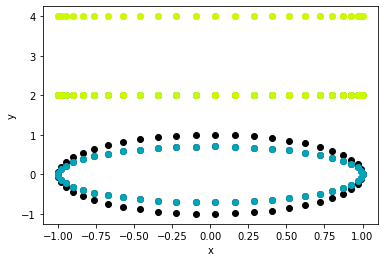

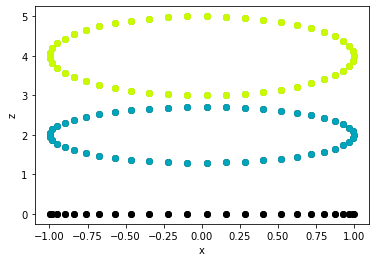

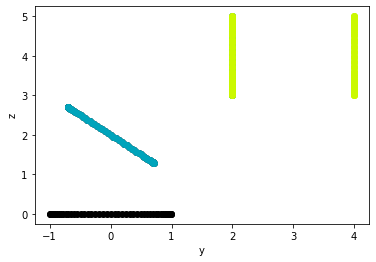

In [51]:
shape.show(x_axis = 'x', y_axis = 'y')
shape.show(x_axis = 'x', y_axis = 'z')
shape.show(x_axis = 'y', y_axis = 'z')

In [52]:
shape.contains([0,1.5,0.5])

False

In [21]:
def random_walk(photon, n_steps, detector, plot_step=False):
    
    photon_steps = [{'location': photon.location, 
                     'direction': {'theta': photon.theta,  'phi': photon.phi}}]
    for step in range(n_steps):
        absorption = random.random()
        if absorption <= scat_length / abs_length: # reverse of what Justin said
            break
       
        # Add a random angle in phi and theta to current direction
        move_theta = math.pi * random.random()   
        move_phi = 2*math.pi * random.random()
        new_theta = add_direction(photon_steps[-1]['direction']['theta'],
                                  photon_steps[-1]['direction']['phi'],
                                  move_theta, move_phi)[0]
        new_phi = add_direction(photon_steps[-1]['direction']['theta'],
                                photon_steps[-1]['direction']['phi'],
                                move_theta, move_phi)[1]
        
        # take a step in x,y,z based on new direction of travel
        dx, dy, dz = conv_spherical_to_cartesian(scat_length, new_theta, new_phi)
        new_loc = [photon_steps[-1]['location'][0]+dx,
                   photon_steps[-1]['location'][1]+dy,
                   photon_steps[-1]['location'][2]+dz]
        photon_steps.append({'location': new_loc, 
                             'direction': {'theta': new_theta,  'phi': new_phi}})
        photon.direction = [new_theta, new_phi] 
        photon.theta = new_theta
        photon.phi = new_phi
        photon.location = new_loc
        
        #Determine if DOM is within visibility region / if a DOM triggers
        visibility_region = VisibilityRegion(photon_steps[-2:], detection_radius)
        
        # Determine if DOMs trigger
        for dom in detector.dom_list:   
            if visibility_region.contains(dom.location): 
                if random.random() <= DOM_QE: 
                    dom.trigger(scat_length*step / c + photon.time)
                break
            else: 
                continue
        break
    
    if plot_step: 
        print(photon_steps[0]['location'][2], photon_steps[-1]['location'][2])
        visibility_region = VisibilityRegion(photon_steps, detection_radius)
        visibility_region.show()
    
        
        #WE DON'T NEED THIS UNLESS IF X_o >= DOM spacing
        # Only trigger the DOM closest to the particle
#         if len(triggered_DOMs) > 1: 
#             closest_dom = triggered_DOMs[0]
#             closest_distance = triggered_DOMs[0].distance_from(charged_particle.location) #is this ok w/ rw
#             for dom in triggered_DOMs: 
#                 if dom.distance_from(charged_particle.location) < closest_distance: #is this ok w/ rw
#                     closest_dom = dom
#                     closest_distance = dom.distance_from(charged_particle.location) #is this ok w/ rw
#             closest_dom.triggered = True
#         elif len(triggered_DOMs) == 1: 
#             triggered_DOMs[0].triggered = True
    return detector

In [36]:
def cherenkov(charged_particle,n_steps,random_walk_n_steps, detector, debug=False): 
    #make cone & see if it intersects w/ detector, 
    # return every Cherenkov photon & its path
    angle = np.arccos(1/(n*charged_particle.beta))
    dNdx = (2*math.pi*(charged_particle.charge**2)
            *alpha*(np.sin(angle)**2)*((1/(400e-9))-(1/(700e-9))))
    N = dNdx * X_o #assuming the electron travels 1 radiation length as it emits Cherenkov radiation
    
    if debug: 
        N = 100
    
    cherenkov_photons = []
    for i in range(n_steps):
        
        print(f"\t\tSimulating Cherenkov step {i} for {int(N/n_steps)} photons")
            
        particle_dx = X_o * i / n_steps
        interaction_time = particle_dx / (charged_particle.beta * c) + charged_particle.time
        
        for photon in range(int(N/n_steps)):
            
            if photon % 1000 == 0: 
                print(f"\t\t\tSimulating photon {photon}")
            
            add_angle = add_direction(charged_particle.direction[0],
                                      charged_particle.direction[1], 
                                      angle, 2*np.pi/N * i)
            
            new_photon = Particle('photon', 0, 0, add_angle, 
                                  charged_particle.location, 
                                  h*c/(450e-9), charged_particle.time + interaction_time) #assumed blue light
            cherenkov_photons.append(new_photon)
            
            if debug:
                if photon%1000 == 0: 
                    detector = random_walk(new_photon, n_steps, detector, 
                                           plot_step=True)
                else: 
                    detector = random_walk(new_photon, n_steps, detector)
            else:
                detector = random_walk(new_photon, n_steps, detector)

            energy_lost = N*h*c/(450e-9)
            charged_particle.update_energy(charged_particle.energy-energy_lost)
        
        # update particle location
        dx, dy, dz = conv_spherical_to_cartesian(particle_dx, 
                                                 charged_particle.theta, 
                                                 charged_particle.phi)
        charged_particle.location = [charged_particle.location[0]+dx,
                                     charged_particle.location[1]+dy,
                                     charged_particle.location[2]+dz]
        
    return(N, detector)

# Simulate Shower

In [23]:
def em_shower(neutrino, steps, n_cher_steps, detector, plot_shower=False, debug=False):
    time = 0.0
    electron = Particle('electron',m_e,-1,
                        neutrino.direction, neutrino.location, neutrino.energy, time)
    particle_plotters = [[np.array([neutrino.location, electron.location])]]
    incoming_particles =[electron]
    for n in range(steps):
        print(f"Simulating EM Shower step {n}")
        outgoing_particles = []
        particle_plotters.append([])
        for particle in incoming_particles:
            new_particles = em_shower_step(particle)
            for new_particle in new_particles: 
                particle_plotters[-1].append(np.array([particle.location, 
                                                       new_particle.location]))
            outgoing_particles.append(new_particles[0])
            outgoing_particles.append(new_particles[1])
        for particle in outgoing_particles:
            if particle.charge != 0:
                print(f"\tSimulating Particle {particle.particle_type}")
                N_photons, detector = cherenkov(particle, n_cher_steps, 
                                                2, detector, debug=debug)
        incoming_particles = outgoing_particles
        
    if plot_shower: 
        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(111, projection='3d')
        colors = color_map(len(particle_plotters))
        
        for i, step in enumerate(particle_plotters): 
            for line in step: 
                ax.plot(line[:,0], line[:,1], line[:,2], color=colors[i])
        
        x_min = None; x_max = None
        y_min = None; y_max = None
        for i, region in enumerate(self.regions):
            x_vals = region.points[region.vertices, axis_index[x_axis]]
            y_vals = region.points[region.vertices, axis_index[y_axis]]
            plt.scatter(x_vals, y_vals, color=colors[i])
            
#             if x_max == None or np.max(x_vals) > x_max: 
#                 x_max = np.max(x_vals)
#             if x_min == None or np.min(x_vals) > x_min: 
#                 x_min = np.min(x_vals)
#             if y_max == None or np.max(y_vals) > y_max: 
#                 y_max = np.max(y_vals)
#             if y_min == None or np.min(y_vals) > y_min: 
#                 y_min = np.min(y_vals)
                
#         plt.xlim(x_min, x_max)
#         plt.ylim(y_min, y_max)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.show()
        return None
        
    return detector

# Running the Simulation for 1 particle

# Create Detector

In [53]:
X, Y, Z = np.mgrid[-20:20:2j, -20:20:2j,-20:20:2j]
locations = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
dom_list = []
for dom in locations:
    dom_list.append(DOM(dom))
IceCube_small = detector(dom_list)    

X, Y, Z = np.mgrid[-500:500:21j, -500:500:21j,-500:500:21j]
locations = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
dom_list = [DOM(loc) for loc in locations]
IceCube = detector(dom_list)

In [54]:
neutrino = Particle('electron neutrino', 0, 0, [0, 1, 0], [20, 20, 20], 1000, 0)

Simulating EM Shower step 0
	Simulating Particle electron
		Simulating Cherenkov step 0 for 20 photons
			Simulating photon 0
20.35933598482172 8.416283611687314


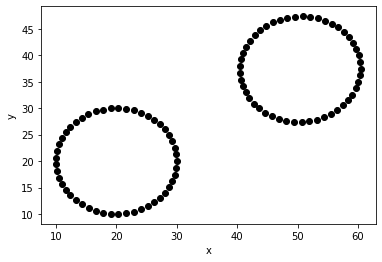

		Simulating Cherenkov step 1 for 20 photons
			Simulating photon 0
20.35933598482172 20.35933598482172


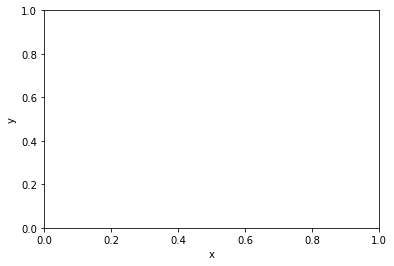

		Simulating Cherenkov step 2 for 20 photons
			Simulating photon 0
20.42656159630732 46.158775430093044


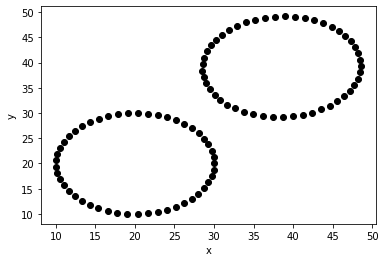

		Simulating Cherenkov step 3 for 20 photons
			Simulating photon 0
20.561012819278524 38.47473711478381


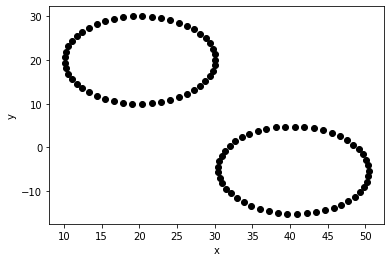

		Simulating Cherenkov step 4 for 20 photons
			Simulating photon 0
20.76268965373533 20.76268965373533


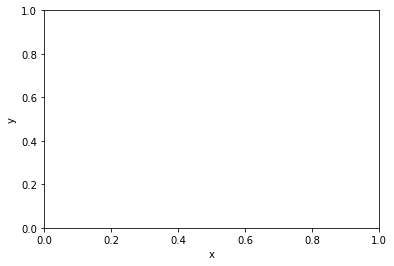

Simulating EM Shower step 1
	Simulating Particle electron
		Simulating Cherenkov step 0 for 20 photons
			Simulating photon 0
48.1400144671034 76.31335185287026


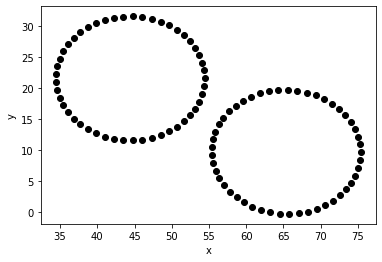

		Simulating Cherenkov step 1 for 20 photons
			Simulating photon 0
48.1400144671034 48.1400144671034


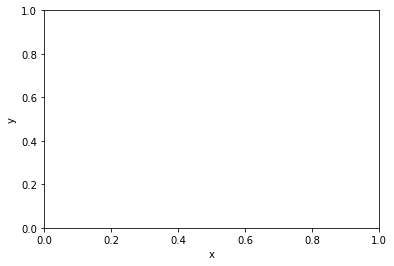

		Simulating Cherenkov step 2 for 20 photons
			Simulating photon 0
48.19391490314063 48.19391490314063


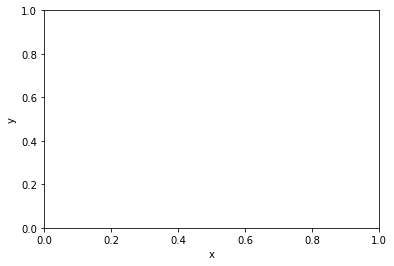

		Simulating Cherenkov step 3 for 20 photons
			Simulating photon 0
48.301715775215094 83.53929012352305


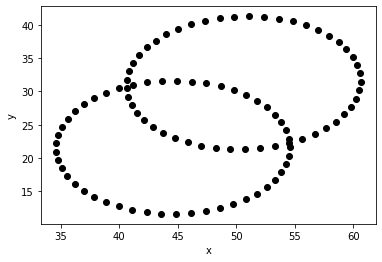

		Simulating Cherenkov step 4 for 20 photons
			Simulating photon 0
48.46341708332679 48.46341708332679


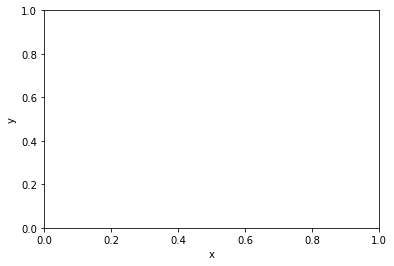

	Simulating Particle positron
		Simulating Cherenkov step 0 for 20 photons
			Simulating photon 0
48.1400144671034 28.64974747530187


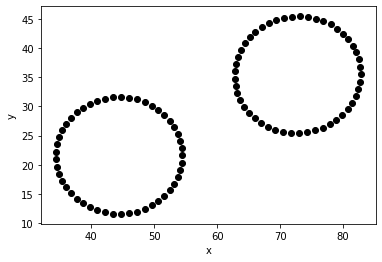

		Simulating Cherenkov step 1 for 20 photons
			Simulating photon 0
48.1400144671034 48.1400144671034


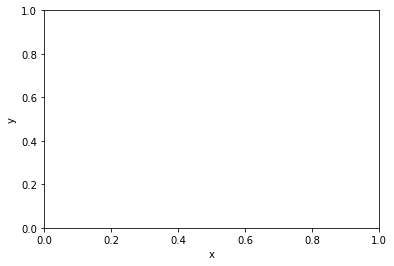

		Simulating Cherenkov step 2 for 20 photons
			Simulating photon 0
48.19391490314063 66.1921863747448


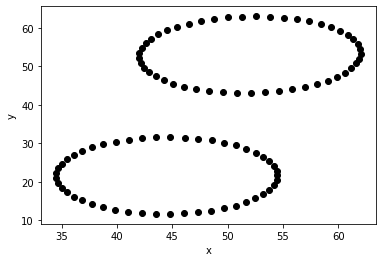

		Simulating Cherenkov step 3 for 20 photons
			Simulating photon 0
48.301715775215094 42.876614980685474


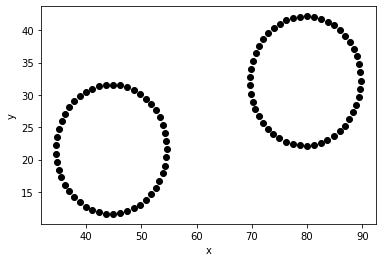

		Simulating Cherenkov step 4 for 20 photons
			Simulating photon 0
48.46341708332679 48.46341708332679


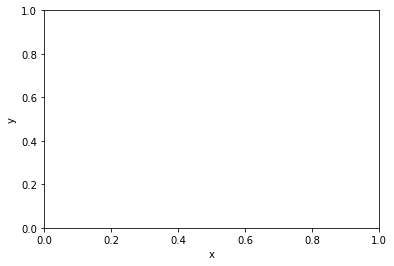

Simulating EM Shower step 2


TypeError: 'NoneType' object is not iterable

In [55]:
IceCube_small = em_shower(neutrino, 3, 5, IceCube_small, debug=True)

In [48]:
IceCube_small.num_triggered()

0

In [39]:
def plot_event(neutrino, detector, 
               title='', filename=None, step=1, show_full_detector=False,
               debug=False):

    hits_pos = [] # doms that trigger
    other_pos = [] # doms that dont
    
    if debug:
        print()
        print(event.get_particle_info()[0])
        
    loc = neutrino.location
    dirn = neutrino.direction
    
    for dom in detector.dom_list:
        if dom.triggered:
            hits_pos.append(dom.location)
        else:
            other_pos.append(dom.location)
    if debug:
        print(*list(hits_pos), sep='\n')
    hits_pos = np.array(hits_pos)
    other_pos = np.array(other_pos)
      
    # plotting the data
    for angle in range(0, 360, step):
        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot hits
        hits = ax.scatter(hits_pos[:, 0], hits_pos[:, 1], hits_pos[:, 2], 
                          marker='o', c='r', s=20)
        
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        zlim = ax.get_zlim()
        dim = max([xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]])
        x = np.mean(xlim)
        y = np.mean(ylim)
        z = np.mean(zlim)
        xlim = [max(x-dim/2, -600), min(x+dim/2, 600)]
        ylim = [max(y-dim/2, -600), min(y+dim/2, 600)]
        zlim = [max(z-dim/2, -600), min(z+dim/2, 600)]
        
        # Plot non-hits
        if show_full_detector: 
            ax.scatter(other_pos[:, 0], other_pos[:, 1], other_pos[:, 2],
                       marker='o', s=10, c='b')
        else: 
            plot_pos = []
            for pos in other_pos:
                if (xlim[0]<pos[0]<xlim[1] and ylim[0]<pos[1]<ylim[1] 
                    and zlim[0]<pos[2]<zlim[1]):
                    plot_pos.append(pos)
            if len(plot_pos) != 0: 
                plot_pos = np.array(plot_pos)
                ax.scatter(plot_pos[:, 0], plot_pos[:, 1], plot_pos[:, 2],
                           marker='o', s=10, c='b')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_zlim(zlim)
        
        # Plot vertex and rays
        ax.scatter(*loc, marker='o', s=10, c='k')
        ax.quiver(*loc, *dirn, color='k', length=100)

        ax.view_init(30, angle)
        
        plt.title(title)
        if filename is not None:
            plt.tight_layout()
            plt.savefig(filename+'_'+str(angle).zfill(3)+'.png', dpi=200)
        if angle%90==45-(45%step):
            plt.show()
        plt.close()

In [ ]:
plot_event(neutrino, IceCube_small)

# Reconstruct an Event

In [118]:
#totally different approach - IceCube usually uses CNNs or max likelihood for this it seems

#compare reconstructed energy to true energy (show that our model is subpar)
def N_observed(E):
    photocathode_efficiency = .25
    absorption = 1 #CHANGE
    beta = np.sqrt(1-(m_e/E)**2)
    Z=1
    N = ((Z**2)*alpha/(h_bar*c))*(1-1/((n*beta)**2))
    Ec = 800/(1.2+Z_nuc)
    return ((2/3)/(photocathode_efficiency*absorption)*X_o*np.log(E/Ec)*(1+(1/np.log(2)))*N*h*c*((1/400e-9)-(1/700e-9)))

data = N_observed(np.logspace(2,3,100))
print(data)

def N_to_energy(N_obs):
    energies = np.logspace(2,3,10000) #if you pass a N_obs corresponding to an E above/below these bounds, the bounding energy will be returned
    return energies[np.argmin(np.abs(data-N_obs))]

N_to_energy(12e6)

[  3574.99618036   4688.94919243   5802.90547201   6916.86479016
   8030.82693203   9144.79169601  10258.75889298  11372.72834561
  12486.69988765  13600.67336332  14714.64862667  15828.62554103
  16942.60397845  18056.58381922  19170.56495135  20284.54727014
  21398.53067774  22512.51508273  23626.50039977  24740.48654922
  25854.47345676  26968.46105315  28082.44927386  29196.43805879
  30310.42735203  31424.41710159  32538.40725915  33652.39777983
  34766.388622    35880.37974706  36994.37111926  38108.3627055
  39222.3544752   40336.34640009  41450.33845413  42564.33061328
  43678.32285546  44792.31516035  45906.30750933  47020.29988532
  48134.29227272  49248.28465728  50362.27702603  51476.26936718
  52590.26167005  53704.25392497  54818.24612326  55932.2382571
  57046.2303195   58160.22230427  59274.21420589  60388.20601951
  61502.19774092  62616.18936646  63730.18089296  64844.1723178
  65958.16363874  67072.154854    68186.14596215  69300.13696212
  70414.12785316  71528.1186

102.30597298425086

In [98]:
#first, we need to reconstruct azimuth and zenith (theta and phi)
def cone(z_init, theta, dx, dy, dz):
    r_vals = z_init*np.tan(theta)
    x_vals = []
    y_vals = []
    z_vals = []
    phi_vals = np.linspace(0,2*np.pi,100)
    for i,(r,z) in enumerate(zip(r_vals,z_init)):
        if i ==0: 
            x_vals = r*np.cos(phi_vals)-dx
            y_vals = r*np.sin(phi_vals)-dy
            z_vals = [z-dz]*100
        else:
            x_vals = np.concatenate((x_vals,r*np.cos(phi_vals)-dx))
            y_vals = np.concatenate((y_vals,r*np.sin(phi_vals)-dy))
            z_vals = np.concatenate((z_vals,[z-dz]*100))
    print(len(x_vals),len(y_vals),len(z_vals))
    return np.array([x_vals, y_vals, z_vals]).T


10000 10000 10000


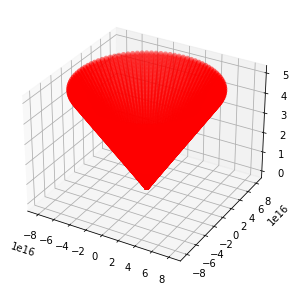

In [100]:
hits_pos_x,hits_pos_y = cone(np.linspace(0,5,100), np.pi/2, 1, 0, 1)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
hits = ax.scatter(hits_pos_x, hits_pos_y, [[z]*100 for z in np.linspace(0, 5, 100)], 
                          marker='o', c='r', s=20)

In [101]:
curve_fit(cone,[[z]*100 for z in np.linspace(0, 5, 100)],[hits_pos_x,hits_pos_y])
#curve_fit(cone, domz, [domx,domy])

10000 10000 10000


TypeError: Improper input: N=4 must not exceed M=2

In [104]:
def func(data, a, b):
    return data[:,0]*data[:,1]*a + b

def func(doms,dx,dy,dz):
    return 

def cone(z_init, theta, dx, dy, dz):
    r_vals = z_init*np.tan(theta)
    x_vals = []
    y_vals = []
    z_vals = []
    phi_vals = np.linspace(0,2*np.pi,100)
    for i,(r,z) in enumerate(zip(r_vals,z_init)):
        if i ==0: 
            x_vals = r*np.cos(phi_vals)-dx
            y_vals = r*np.sin(phi_vals)-dy
            z_vals = [z-dz]*100
        else:
            x_vals = np.concatenate((x_vals,r*np.cos(phi_vals)-dx))
            y_vals = np.concatenate((y_vals,r*np.sin(phi_vals)-dy))
            z_vals = np.concatenate((z_vals,[z-dz]*100))
    print(len(x_vals),len(y_vals),len(z_vals))
    return np.array([x_vals, y_vals, z_vals]).T

A = np.array([(19,20,24), (10,40,28), (10,50,31)])

guess = (1,1)
params, pcov = curve_fit(func, A[:,:2], A[:,2], guess)
print(params)

[0.04919355 6.67741929]


# Simulating Multiple Neutrinos

In [44]:
IceCube_small.dom_list[0].triggered=True
IceCube_small.dom_list[1].triggered=True
IceCube_small.dom_list[2].triggered=True

In [56]:
def effective_volume(detector, n_sim, n_triggered):
    volume = detector.volume()
    return n_triggered / n_sim * volume

def effective_area(v_eff, int_length_neutrino): 
    # Maybe incorrect
    return v_eff / int_length_neutrino